# Predicting If NBA Players Return the Following Season

This project will use data from [basketball-reference.com](https://www.basketball-reference.com/) gathered by Omri Goldstein available at [kaggle](https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv) to create a model that is fed a player's season statistics and can predict whether that player will be playing in the NBA in the following season. Such a model would be beneficial to the following parties:

### Teams:
In NBA team building, making sure that you are allocating resources within the salary cap to productive players is one of the greatest challenges. Oftentimes a team will give a large contract to a player that does not live up to the production expected of such a contract, thus hamstringing the salary space of a team. Finding players who will live up to, or even out-perform, their salary is a must in smart team building. Also, for a [variety of reasons](https://www.sbnation.com/2019/3/13/18261437/nba-trade-rumors-adam-silver-lebron-james-max-contract) surrounding the Collective Bargaining Agreement (CBA) between the team owners and the players' association, player contracts are getting shorter and player movement is therefore increasing. Teams therefore are making the decisions on who to give contracts to in summer free agency more often, with increasingly half the roster or more as free agents. This 2019 free agency period saw about 40% of the league sign new deals, meaning teams had to decide on almost half the league on what kind of deal to give to a player, and who to even give them to.

With all that being said, a model that can use historial player data to predict when a player is probably playing their final season can help a team in two ways: 1) It is another tool in the toolbox to evaluate player performance -- if a player is likely playing their last season, that likely means they are not living up to their contract and should be a stay-away in upcoming free agency. 2) If the model assigns a player as likely playing their last season, but the teams' front office and scouts like some aspect of the player's game, this player could be a very cheap option to target in free agency as other teams are likely to pass up the player due to perceived deficiencies. 

### Player Agents:
A model that can predict if a player is in their final season can be a warning signal to a player agent  and help them prepare their player for this in several ways. They can push for more playing time and opportunity for a young player who is being predicted to wash out of the league. They can explore opportunities to play overseas and attempt to procure lucrative contracts in international leagues in case a new contract doesn't come in the NBA. They can also engage the player with the model prediction and check whether retirement is something the player wants to do on their terms, rather than face the prospect of wanting to play and have no team want you in return, a potentially embarrassing position.

### NBA Media and Consumers:
The last party that I see gaining value from such a model is simply those who follow the NBA. Media companies who cover the NBA and monetize their coverage could use such a tool as another way to create content and therefore clicks/listens/views. NBA fans could also theoretically see which players are being projected to play their last season and try to find prop bets for a player to not return to the nba after this season.



With all that being said as to such a model's value, I will now get to the code that creates the model, breaking down my process step-by-step.

In [1]:
# Module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix
import imblearn
from imblearn.combine import SMOTETomek

# Set the random seed, set the graphs style, and suppress unneeded warnings
np.random.seed(42)
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Data Wrangling and Cleaning

In [2]:
nba = pd.read_csv('Seasons_Stats.csv', index_col=0)

In [3]:
nba.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [4]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24691 entries, 0 to 24690
Data columns (total 52 columns):
Year      24624 non-null float64
Player    24624 non-null object
Pos       24624 non-null object
Age       24616 non-null float64
Tm        24624 non-null object
G         24624 non-null float64
GS        18233 non-null float64
MP        24138 non-null float64
PER       24101 non-null float64
TS%       24538 non-null float64
3PAr      18839 non-null float64
FTr       24525 non-null float64
ORB%      20792 non-null float64
DRB%      20792 non-null float64
TRB%      21571 non-null float64
AST%      22555 non-null float64
STL%      20792 non-null float64
BLK%      20792 non-null float64
TOV%      19582 non-null float64
USG%      19640 non-null float64
blanl     0 non-null float64
OWS       24585 non-null float64
DWS       24585 non-null float64
WS        24585 non-null float64
WS/48     24101 non-null float64
blank2    0 non-null float64
OBPM      20797 non-null float64
DBPM      2

In [5]:
# I can drop two blank columns that have no information
nba = nba.drop(columns=['blanl', 'blank2'])

To make sure that I am working with complete data and to remove all data prior to the modern era that generally began in the 1980's, I will drop all columns that have missing data. Many of the more sophisticated statistics were not tracked in the early decades of the league.

In [6]:
nba = nba.dropna(axis=0, how='any')
nba = nba.reset_index(drop=True)
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14585 entries, 0 to 14584
Data columns (total 50 columns):
Year      14585 non-null float64
Player    14585 non-null object
Pos       14585 non-null object
Age       14585 non-null float64
Tm        14585 non-null object
G         14585 non-null float64
GS        14585 non-null float64
MP        14585 non-null float64
PER       14585 non-null float64
TS%       14585 non-null float64
3PAr      14585 non-null float64
FTr       14585 non-null float64
ORB%      14585 non-null float64
DRB%      14585 non-null float64
TRB%      14585 non-null float64
AST%      14585 non-null float64
STL%      14585 non-null float64
BLK%      14585 non-null float64
TOV%      14585 non-null float64
USG%      14585 non-null float64
OWS       14585 non-null float64
DWS       14585 non-null float64
WS        14585 non-null float64
WS/48     14585 non-null float64
OBPM      14585 non-null float64
DBPM      14585 non-null float64
BPM       14585 non-null float64
VOR

In [7]:
nba.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1980.0,Tiny Archibald*,PG,31.0,BOS,80.0,80.0,2864.0,15.3,0.574,...,0.830,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0
1,1980.0,Larry Bird*,PF,23.0,BOS,82.0,82.0,2955.0,20.5,0.538,...,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,1745.0
2,1980.0,M.L. Carr,SF,29.0,BOS,82.0,7.0,1994.0,14.6,0.526,...,0.739,106.0,224.0,330.0,156.0,120.0,36.0,143.0,214.0,914.0
3,1980.0,Don Chaney,SG,33.0,BOS,60.0,0.0,523.0,7.8,0.402,...,0.762,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0
4,1980.0,Dave Cowens*,C,31.0,BOS,66.0,55.0,2159.0,14.8,0.477,...,0.779,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0


In [8]:
# There are also random asterisks in some of the names that I need to clean out
nba['Player'] = nba['Player'].map(lambda x: x.replace('*', ''))

In [9]:
nba.Year.describe()

count    14585.000000
mean      2001.217552
std         10.228267
min       1980.000000
25%       1993.000000
50%       2002.000000
75%       2010.000000
max       2017.000000
Name: Year, dtype: float64

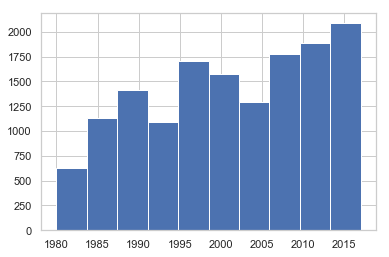

In [10]:
nba.Year.hist()

I will now make the target variable, whether a nba player returns to play the following year.

In [11]:
nba['Returned'] = np.nan

for i, player in enumerate(nba['Player']):
    next_year = int(nba.loc[i, 'Year']) + 1
    if ((nba['Player'] == player) & (nba['Year'] == next_year)).any() == True:
        nba.loc[i, 'Returned'] = 1
    else:
        nba.loc[i, 'Returned'] = 0

I now need to drop all of the data that is from the year 2017, as that data is now all coded 0 for not returned since that is the last year in the data. This would significantly skew the data if I left it in.

In [12]:
nba = nba.drop(index=nba[nba['Year'] == 2017].index)

nba = nba.reset_index(drop=True)

In [13]:
nba.Returned.value_counts()

1.0    10749
0.0     3305
Name: Returned, dtype: int64

I will now also remove the rows where a player split the year between two or more teams. The basketball reference site has an entry for such a player's year totals under the team "TOT" as well as two or more rows that show just the season split data for while they were with a particular team that season. The the data rows that split the season by teams are not necessarry and would skew the data as it is a replicated subsection of existing data in the "TOT row.

In [14]:
index = []

for i, player in enumerate(nba['Player']):
    year = nba.loc[i, 'Year']
    # If for any given combination of player and year there is a row where the team is TOT for total,
    # add the rows that are season splits for each team in that year to the index list
    if ((nba['Year'] == year) & (nba['Player'] == player) & (nba['Tm'] == 'TOT')).any() == True:
        season_split_index = nba[(nba['Year'] == year) & (nba['Player'] == player) & (nba['Tm'] != 'TOT')].index.tolist()
        index.append(season_split_index)

In [15]:
# Flatten out index lists to single list to work with
flat_index = []
for sublist in index:
    for item in sublist:
        flat_index.append(item)
# Delete duplicates
index = list(dict.fromkeys(flat_index))

for x in index:
    nba = nba.drop(index=x)

In [16]:
nba = nba.reset_index(drop=True)

I now have a fully cleaned and complete dataset to work with.

# Data Exploration

I will now visualize and run statistical analyses on the data to better understand it before doing any feature engineering.

In [17]:
nba.describe(include='all')

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Returned
count,11915.000000,11915,11915,11915.000000,11915,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,...,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000
unique,NaN,2251,16,NaN,41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Eddie Johnson,SG,NaN,TOT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,21,2672,NaN,1246,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2000.306085,NaN,NaN,26.792195,NaN,59.720352,30.136299,1460.829039,13.383156,0.514132,...,71.089887,174.911540,246.001427,145.643475,49.933277,27.764499,91.206798,131.189425,622.710197,0.774990
std,9.933253,NaN,NaN,4.007123,NaN,21.976307,30.449418,900.693507,4.589335,0.061160,...,68.032786,145.090032,206.216648,150.497076,39.312488,37.767335,67.737654,76.570895,496.549191,0.417607
min,1980.000000,NaN,NaN,18.000000,NaN,1.000000,0.000000,7.000000,-23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1992.000000,NaN,NaN,24.000000,NaN,46.000000,2.000000,673.000000,10.600000,0.484000,...,20.000000,64.000000,89.000000,39.000000,19.000000,5.000000,36.000000,68.000000,213.000000,1.000000
50%,2001.000000,NaN,NaN,26.000000,NaN,67.000000,17.000000,1435.000000,13.300000,0.520000,...,49.000000,142.000000,195.000000,97.000000,42.000000,15.000000,78.000000,131.000000,511.000000,1.000000
75%,2009.000000,NaN,NaN,29.000000,NaN,78.000000,61.000000,2206.000000,16.000000,0.552000,...,102.000000,244.000000,343.000000,200.000000,71.000000,34.000000,133.000000,188.000000,921.000000,1.000000


### Univariate Distribution Visualizations

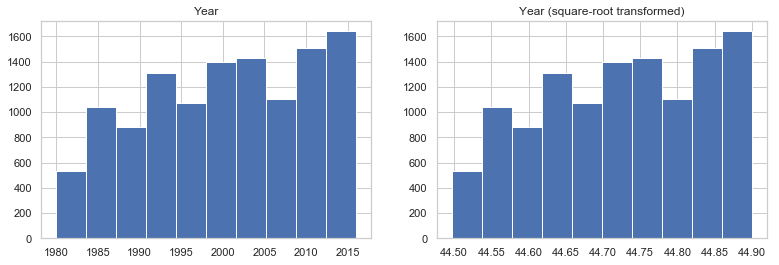

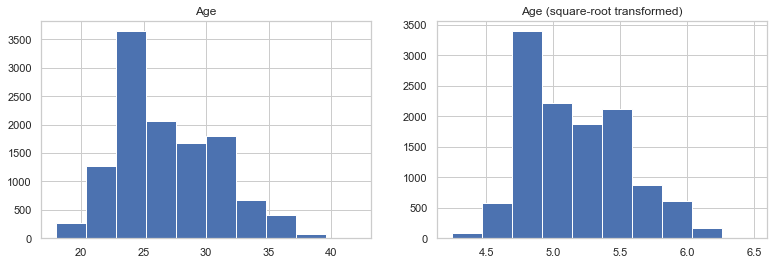

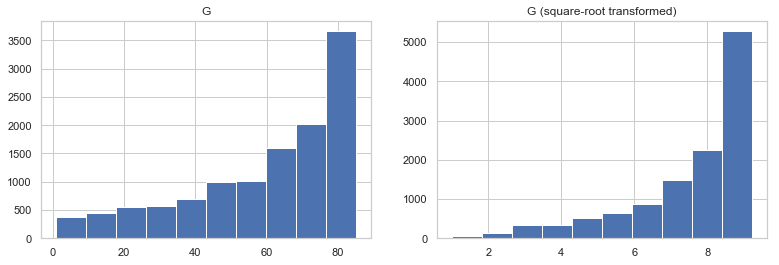

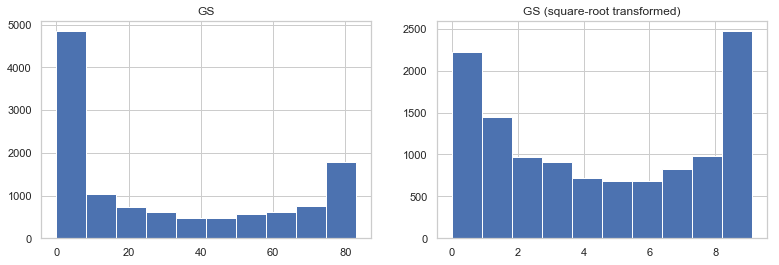

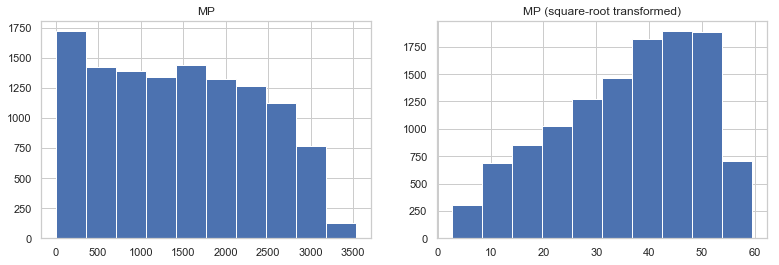

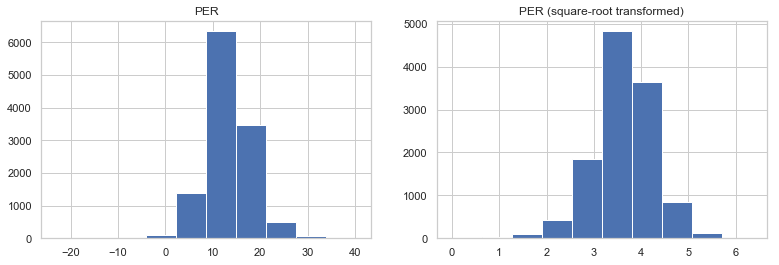

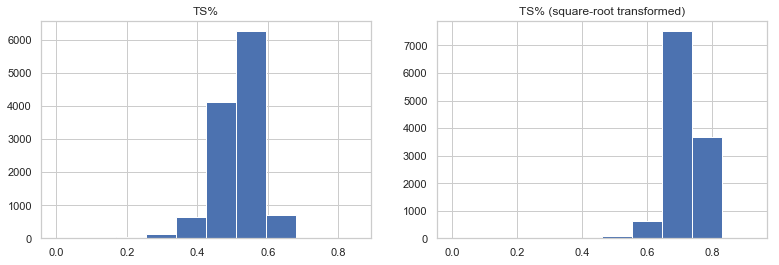

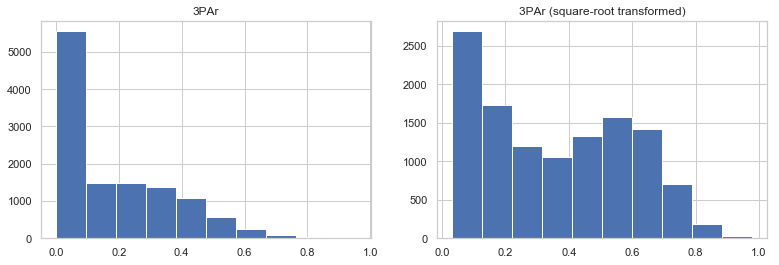

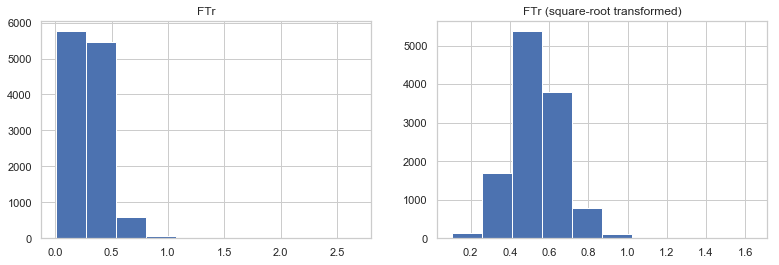

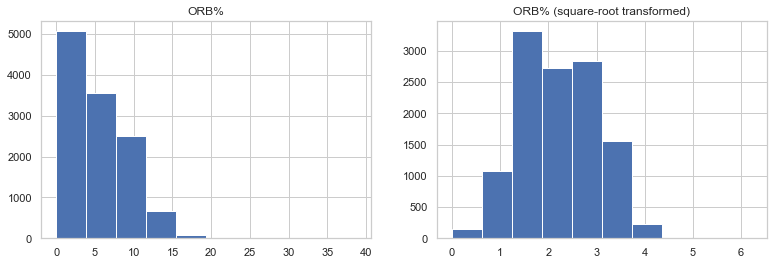

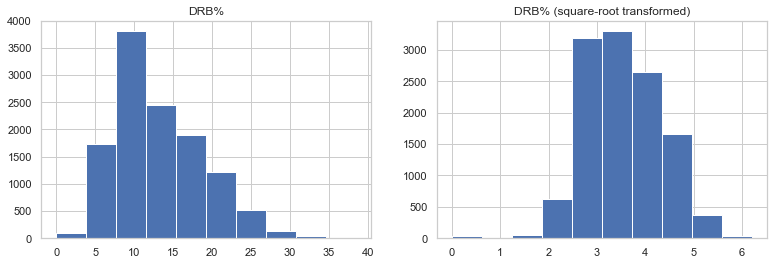

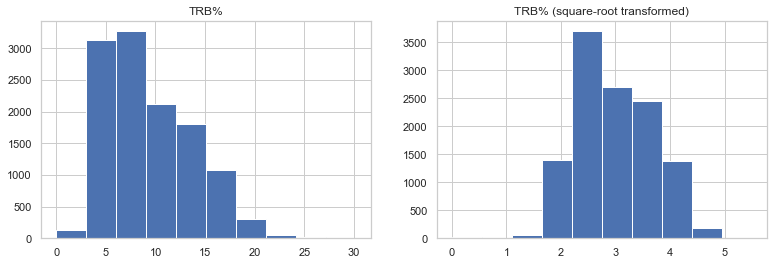

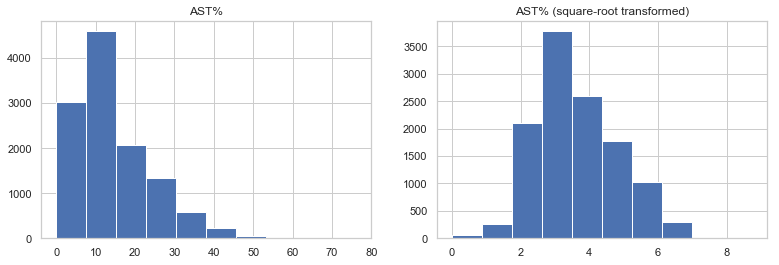

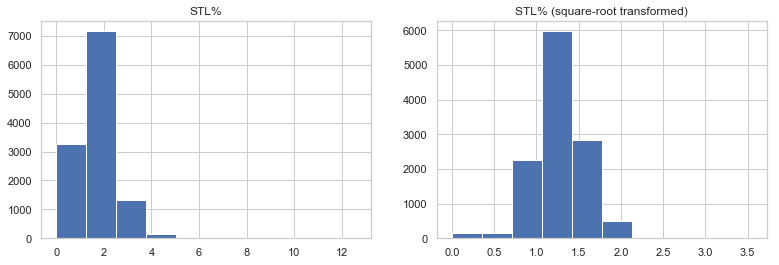

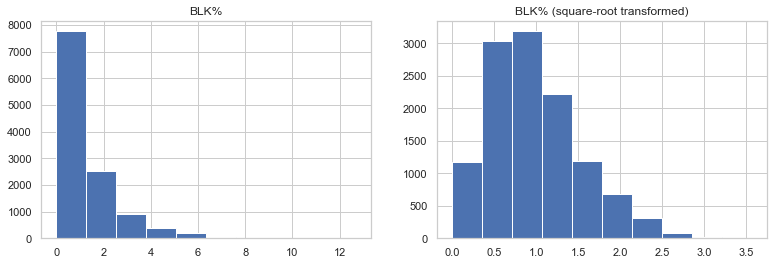

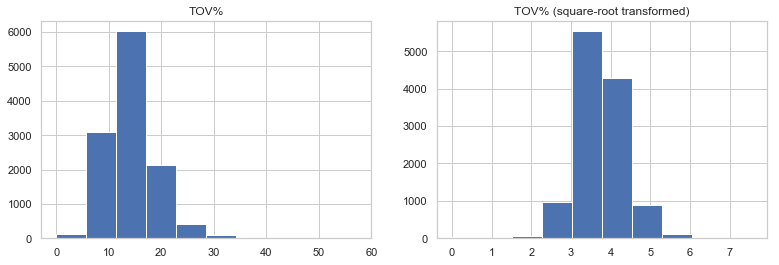

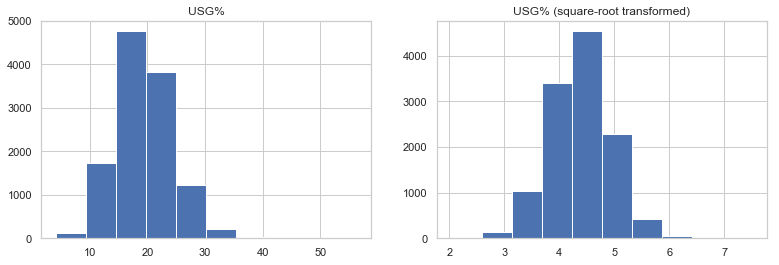

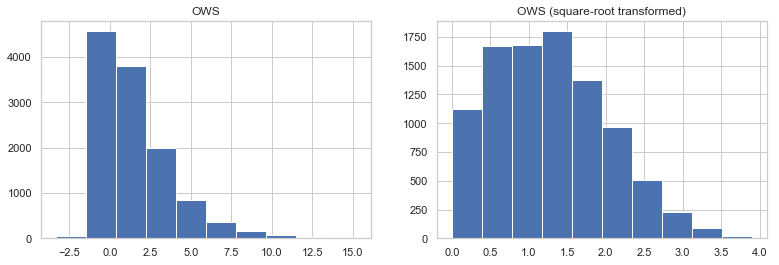

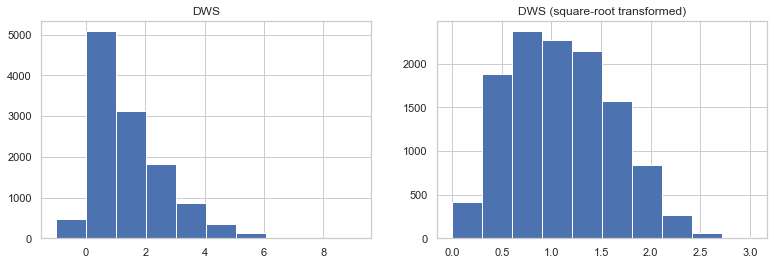

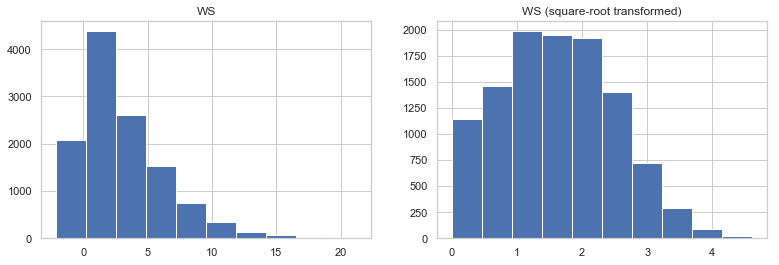

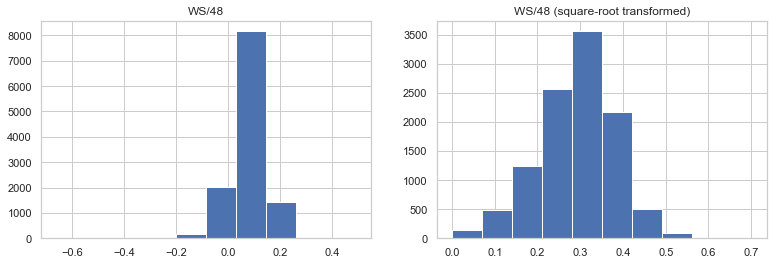

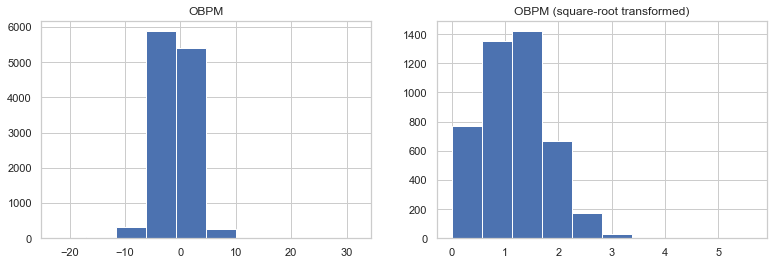

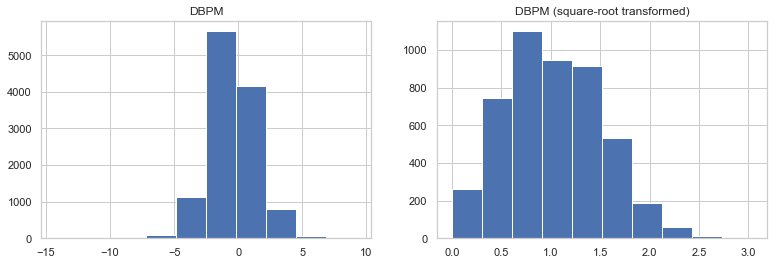

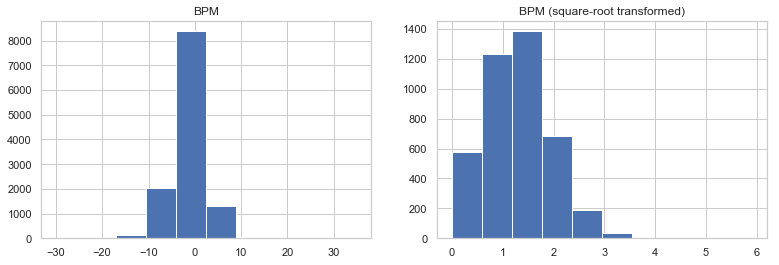

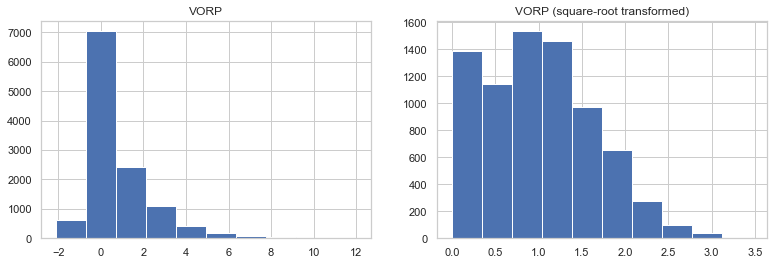

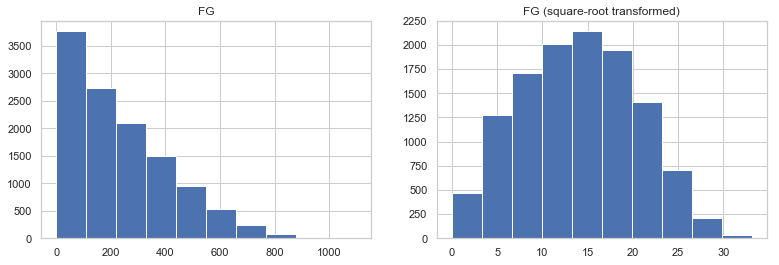

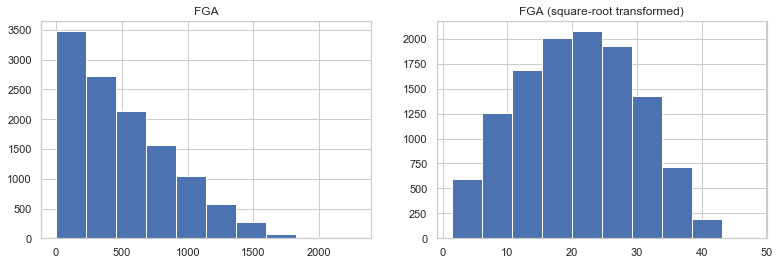

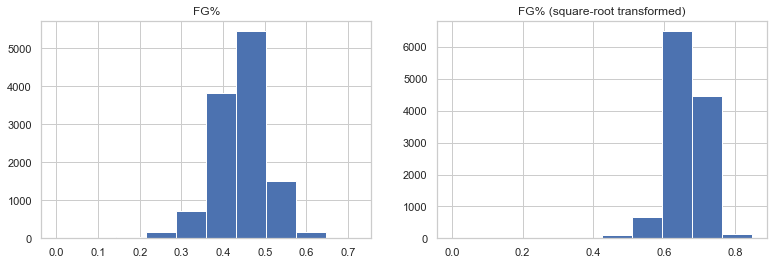

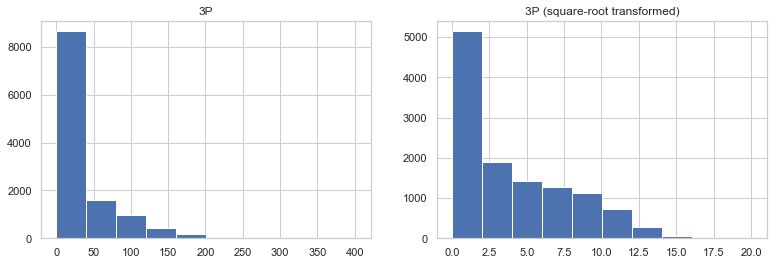

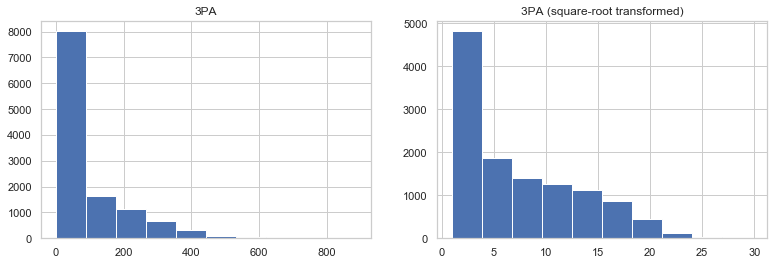

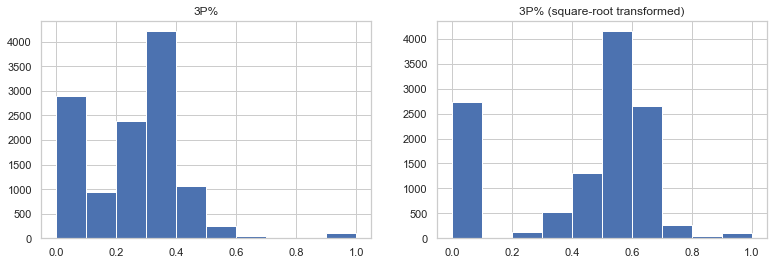

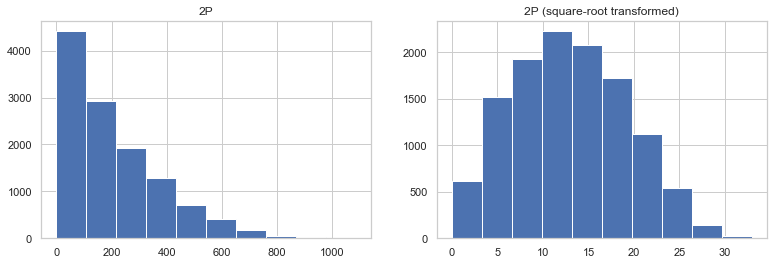

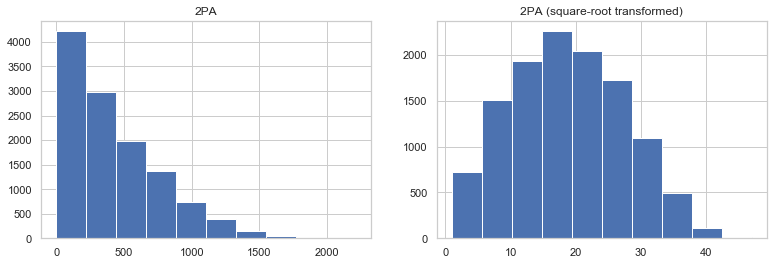

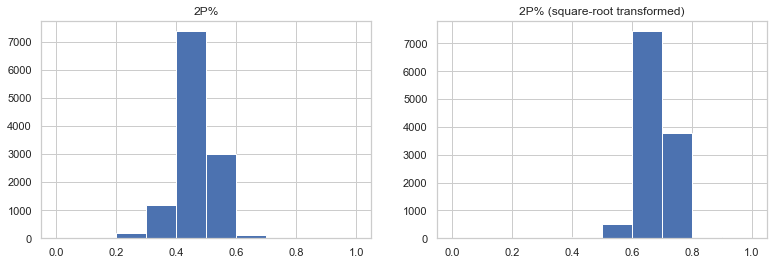

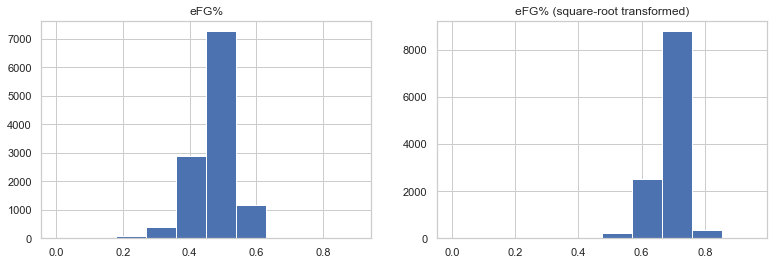

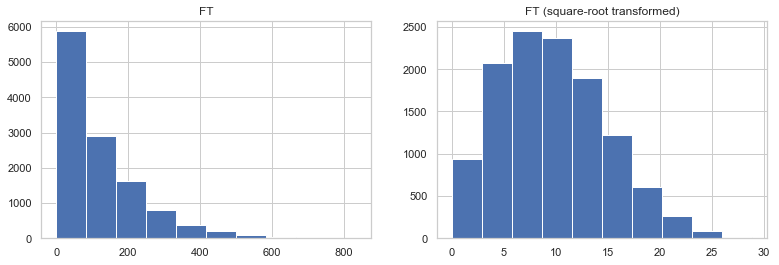

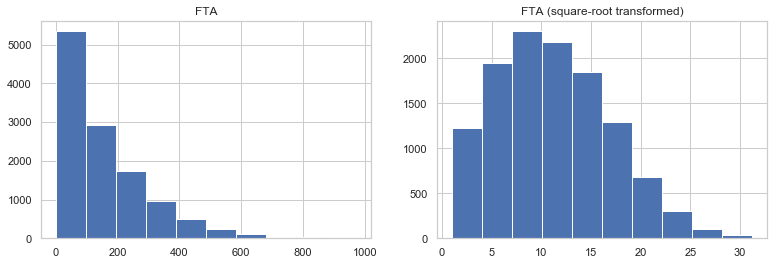

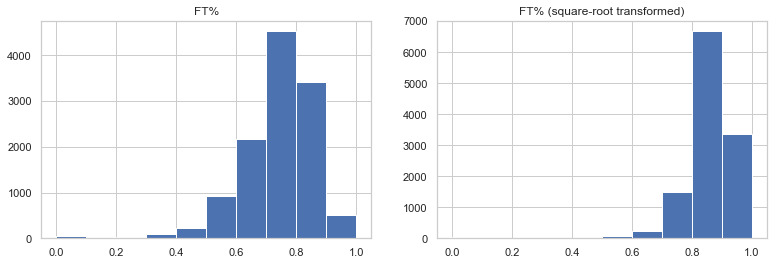

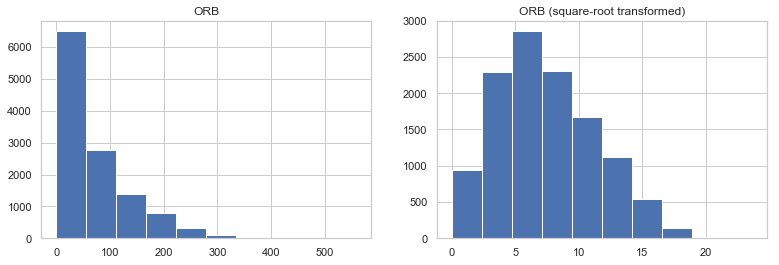

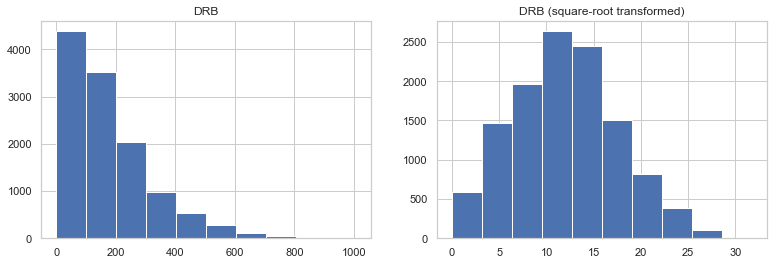

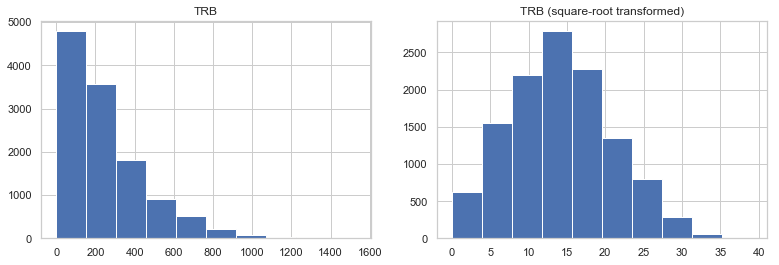

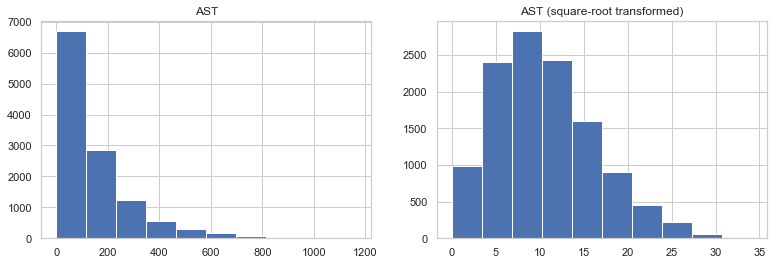

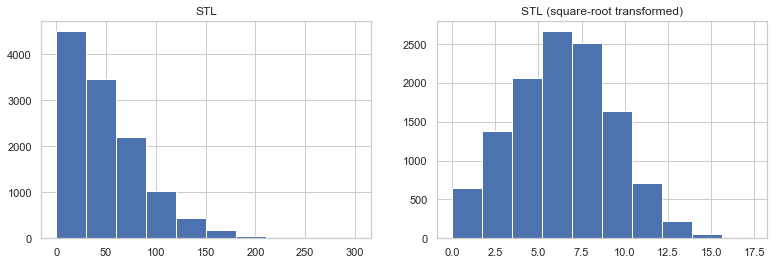

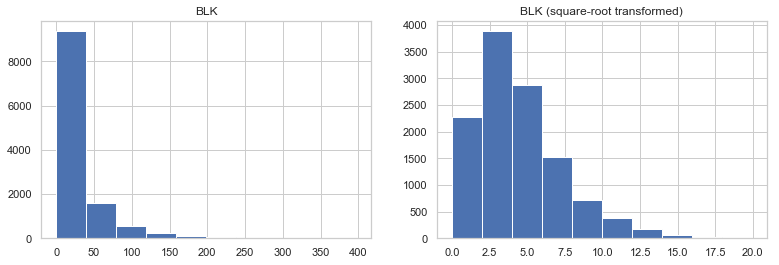

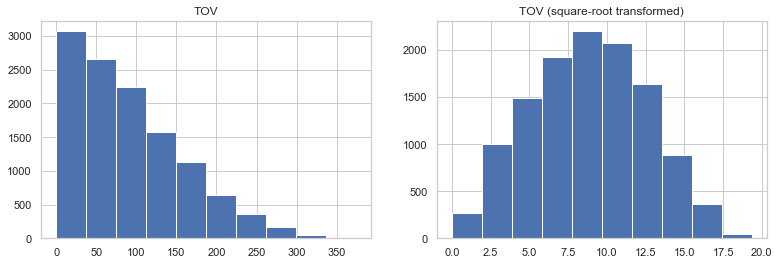

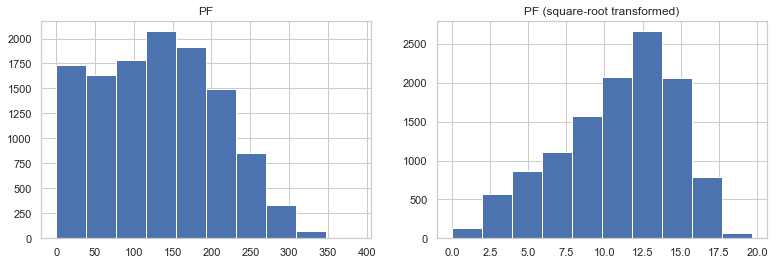

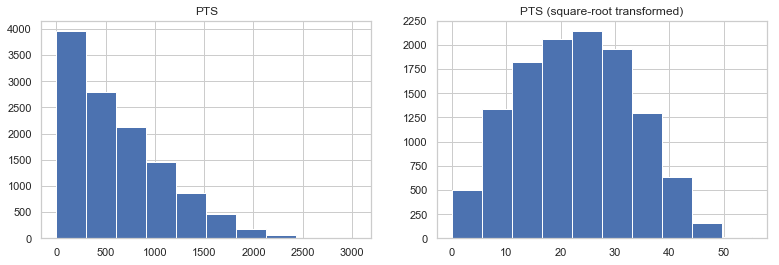

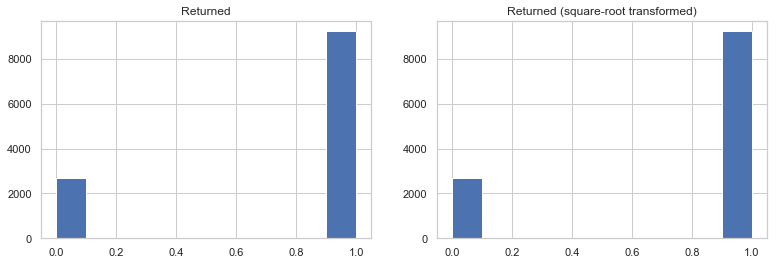

In [18]:
for x in nba.drop(columns=['Player', 'Pos', 'Tm']):
    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    plt.hist(nba[x])
    plt.title(x)
    plt.subplot(1,2,2)
    plt.hist(np.sqrt(nba[x]))
    plt.title('{} (square-root transformed)'.format(x))
    plt.show()

In some cases, the square root transformation gave more normality to the data. Log transformations did not work with most of the variables when attempted. Also, in practical experimentation with the data, when I attempted the square root transformation it left many variables with inf and nan values. The best I am going to be able to do to deal with non-normality is later in the process by dealing with outliers through winsorization and by normalizing the data during feature engineering.

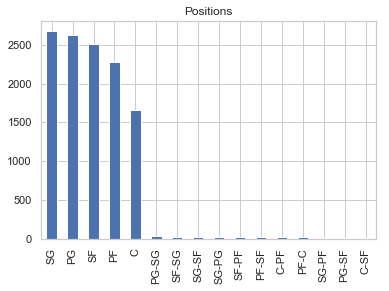

In [19]:
nba['Pos'].value_counts().plot(kind='bar', title='Positions')

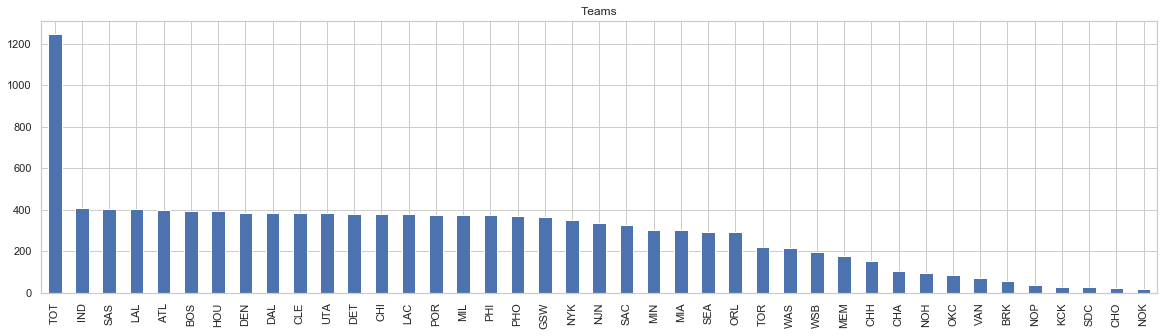

In [20]:
plt.figure(figsize=(20,5))
nba['Tm'].value_counts().plot(kind='bar', title='Teams')

None of the distributions show a concerning level outlierness, with the exception of TOT for team. This is not actually a team in the NBA, but represents when a player played for multiple teams during a season due to trade, being cut and signing with a new team, etc. As this represents a huge variety of scenarios and combinations of teams, I am not concerned with it representing an actual outlier.

### Bivariate and multivariate Visualizations and Statistics

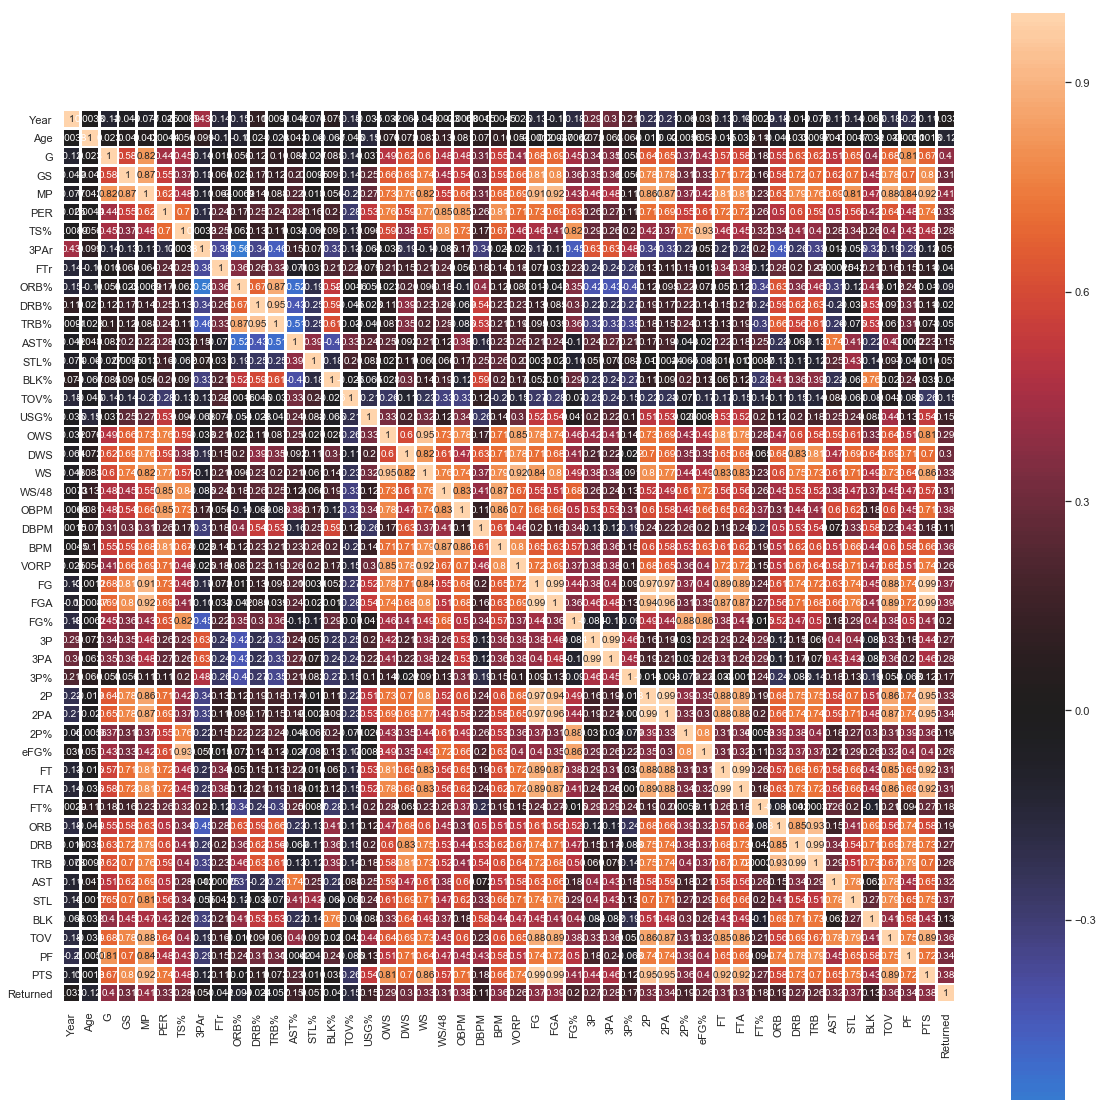

In [21]:
corrmat = nba.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, center=0, annot=True, square=True, linewidths=2)

Inspecting this heatmap, I can see multiple pockets of correlation. Using PCA to reduce dimensionality will be crucial with this data.

In [22]:
# Test whether differences between Returned or Not Returned groups are significant for each other variable
for col in nba.drop(columns=['Player', 'Tm', 'Pos']).columns:
    print(col)
    print(stats.ttest_ind(
        nba[nba['Returned'] == 0][col],
        nba[nba['Returned'] == 1][col]
    ))

Year
Ttest_indResult(statistic=-3.6031423727868224, pvalue=0.0003156742510146172)
Age
Ttest_indResult(statistic=13.135298205654912, pvalue=3.864735216353367e-39)
G
Ttest_indResult(statistic=-47.0668825955258, pvalue=0.0)
GS
Ttest_indResult(statistic=-35.42811974975059, pvalue=1.7552131654873184e-261)
MP
Ttest_indResult(statistic=-49.718866725250344, pvalue=0.0)
PER
Ttest_indResult(statistic=-37.88649805712737, pvalue=1.1252446448727403e-296)
TS%
Ttest_indResult(statistic=-31.868843378981087, pvalue=5.952418903579726e-214)
3PAr
Ttest_indResult(statistic=-5.584151646512166, pvalue=2.3998602090699e-08)
FTr
Ttest_indResult(statistic=4.60280232042185, pvalue=4.211515924862568e-06)
ORB%
Ttest_indResult(statistic=10.906928251388669, pvalue=1.4416622184341263e-27)
DRB%
Ttest_indResult(statistic=2.6207603127041885, pvalue=0.008784530898474648)
TRB%
Ttest_indResult(statistic=6.191172174344944, pvalue=6.168225146539603e-10)
AST%
Ttest_indResult(statistic=-16.993459999466378, pvalue=5.200539144124

In every single variable, there is a statistically significant difference between those player-year stat profiles that return to the nba the following season and those that don't. This is a good sign for us moving forward. Hopefully our model will be able to catch these differences.

I will now create box plots to show the distributions of each variable broken down by the "not returning" (0) or "returning" (1) variable.

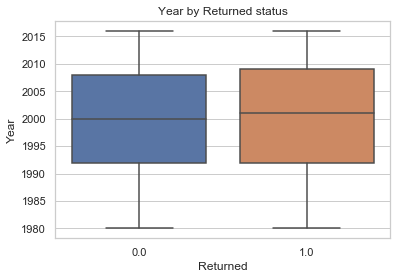

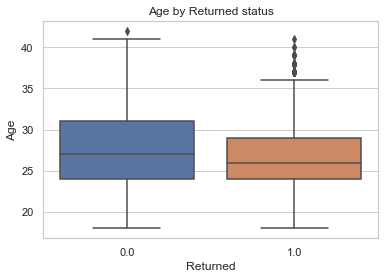

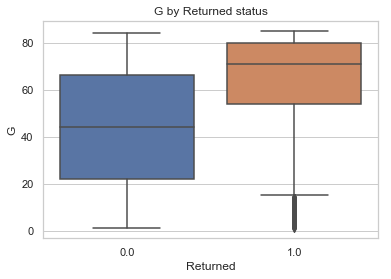

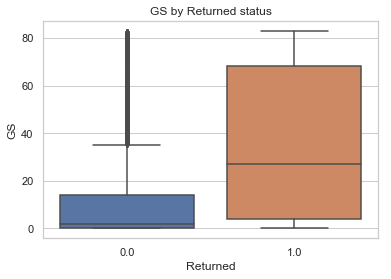

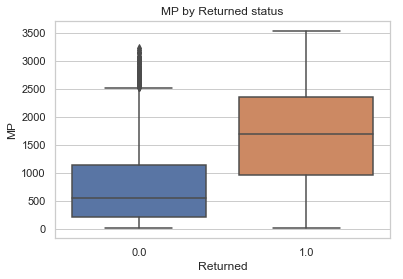

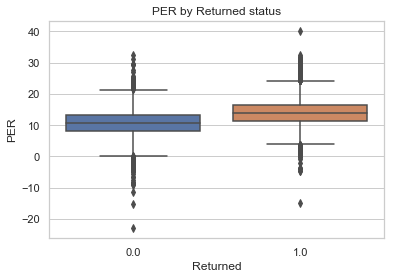

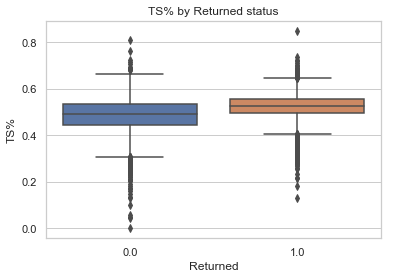

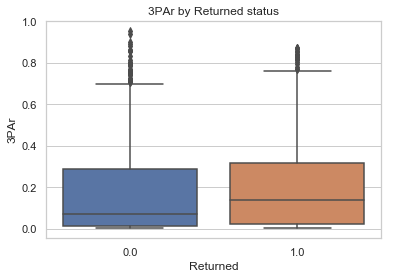

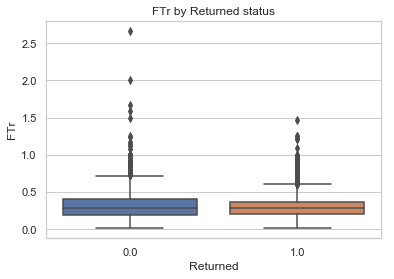

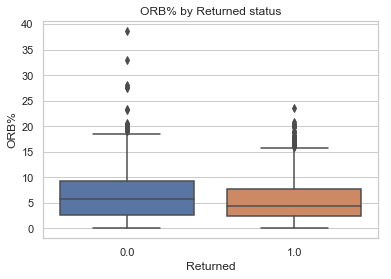

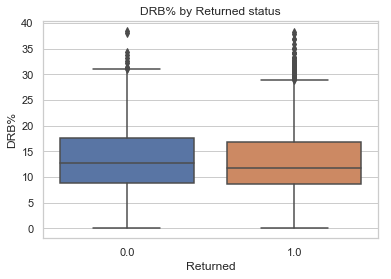

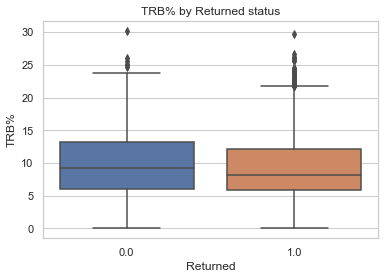

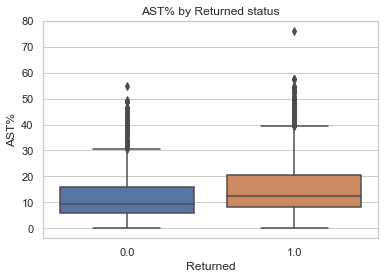

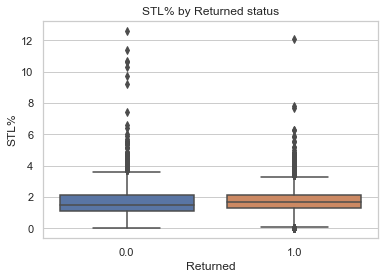

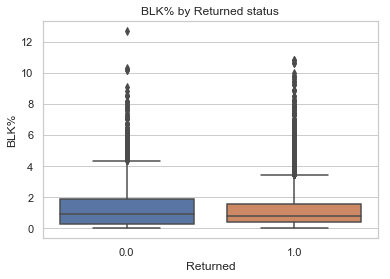

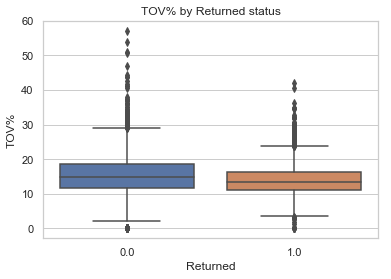

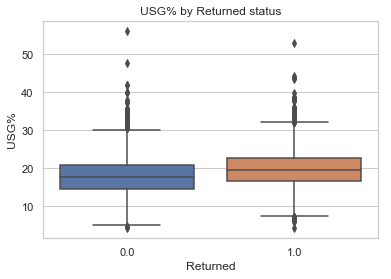

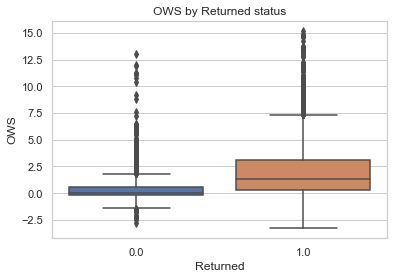

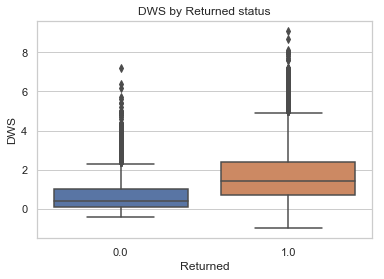

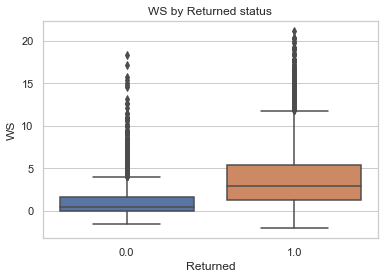

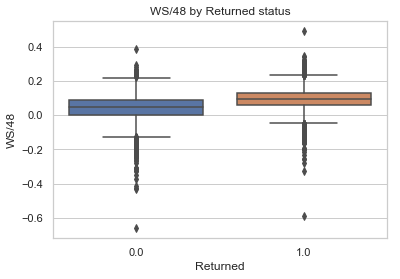

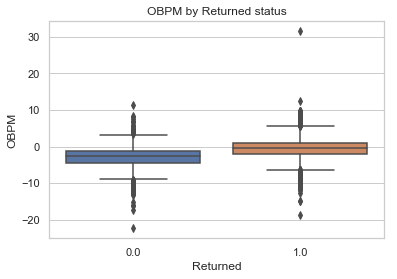

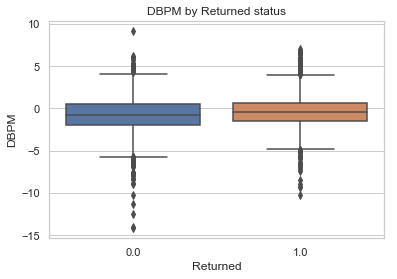

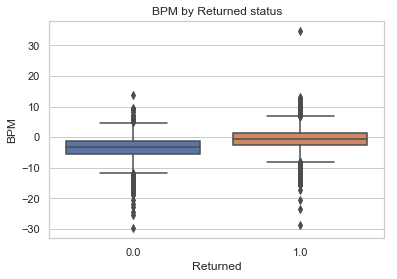

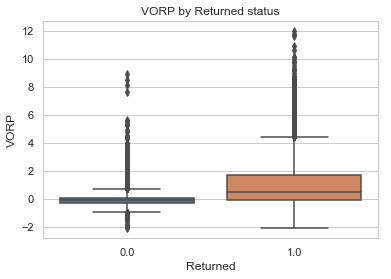

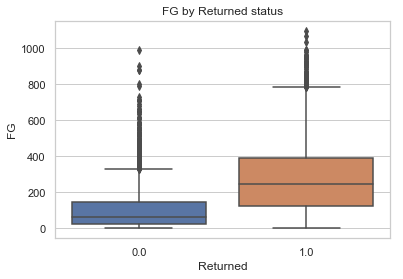

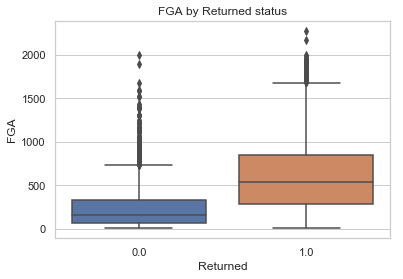

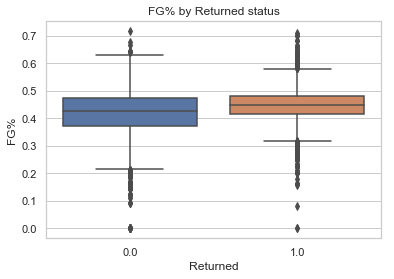

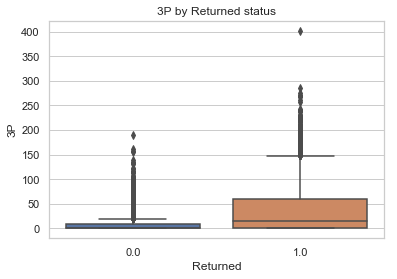

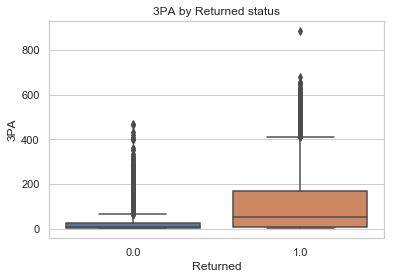

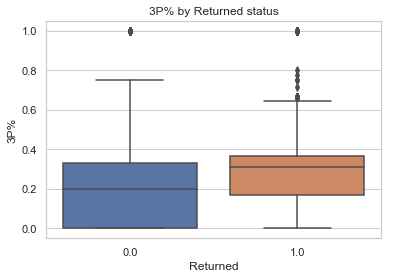

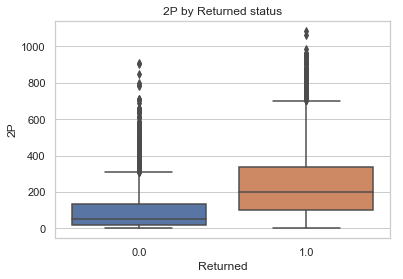

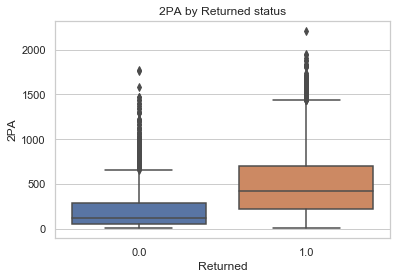

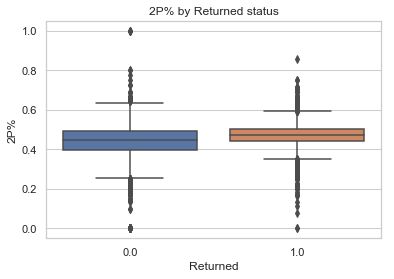

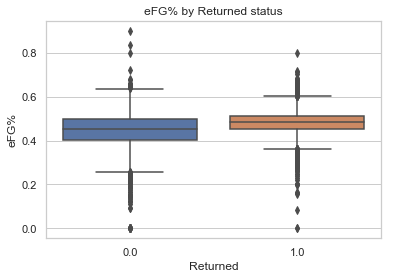

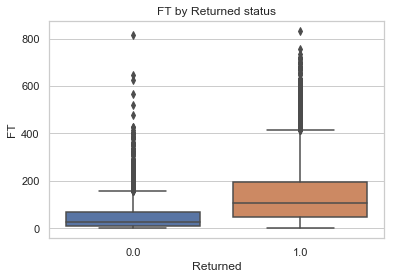

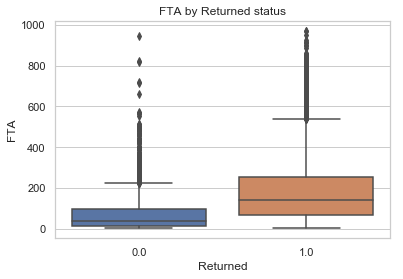

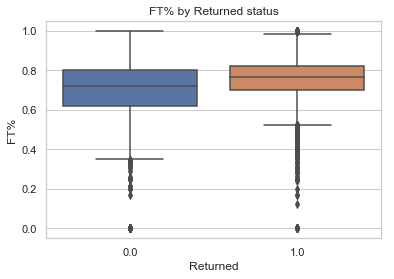

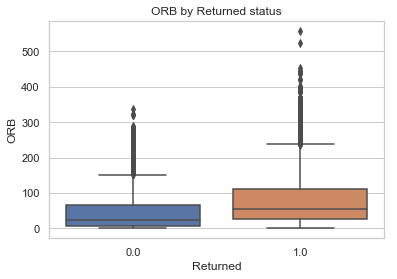

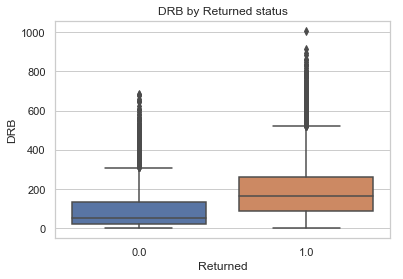

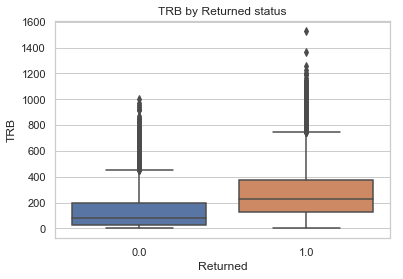

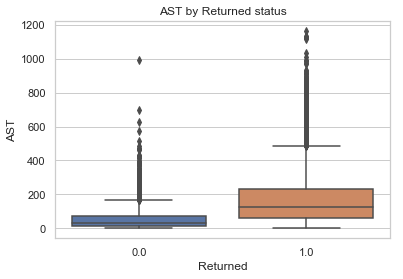

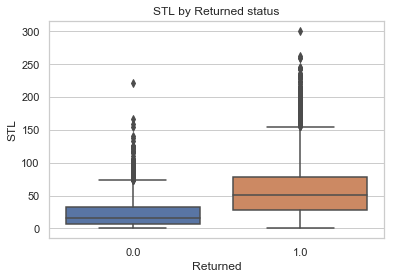

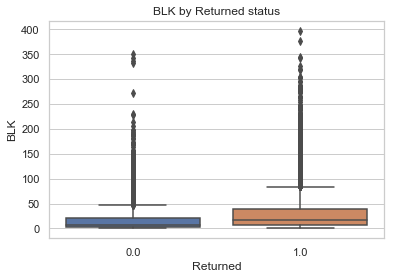

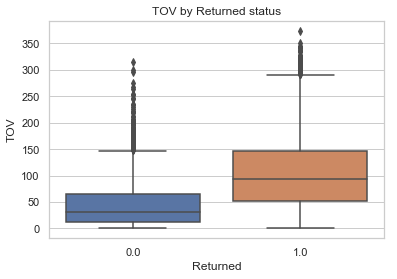

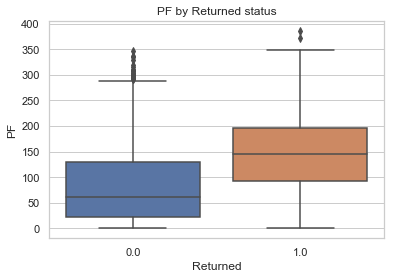

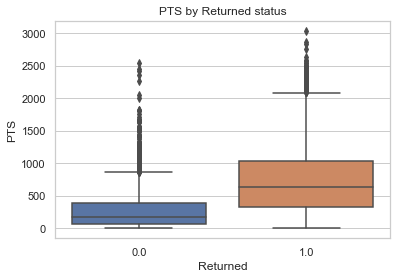

In [23]:
for col in nba.drop(columns=['Player', 'Tm', 'Pos']):
    if col != 'Returned':
        sns.boxplot(x='Returned', y=col, data=nba)
        plt.title('{} by Returned status'.format(col))
        plt.show()
        plt.close()

### Outliers
Upon looking at the boxplots, now is a good time to address outliers. I am going to perform winsorization to cap the values of the outliers for each variable based on visual inspection. Winsorization sets all values beyond a certain percentile (either above or below, depending on if we are talking about outliers that are too high or too low) to the value present at the percentile that you choose. I will create groups that need to be capped at the top, capped at the bottom, or capped on both ends. I will then winsorize accordingly using a 90% threshold.

In [24]:
top_cap = ['3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
          'OWS', 'DWS', 'WS', 'VORP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 
          'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

both_cap = ['PER', 'TS%', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'FG%', '2P%', 'eFG%']

bottom_cap = 'FT%'

# One-way winsorization on the top
for col in nba[top_cap]:
    nba[col] = winsorize(nba[col], (0, 0.10))
    
# Two-way winsorization
for col in nba[both_cap]:
    nba[col] = winsorize(nba[col], (0.10, 0.10))

# One-way winsorization on the bottom (Just FT%)
nba[bottom_cap] = winsorize(nba[bottom_cap], (0.10, 0))

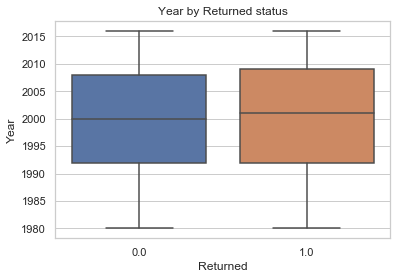

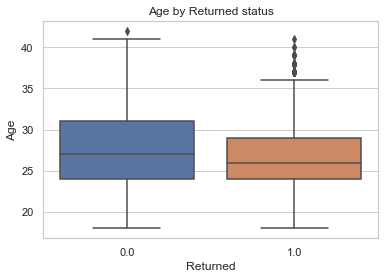

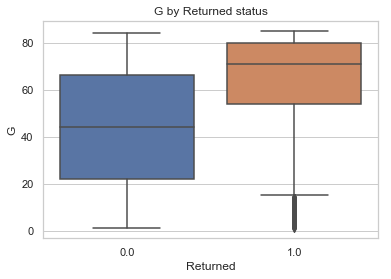

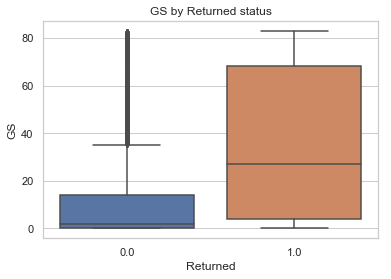

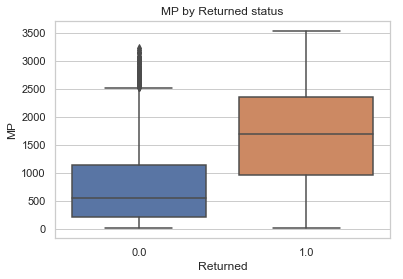

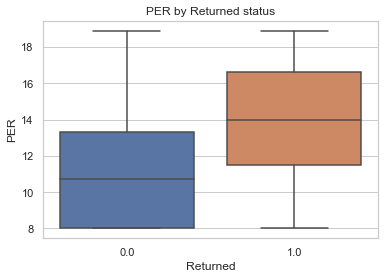

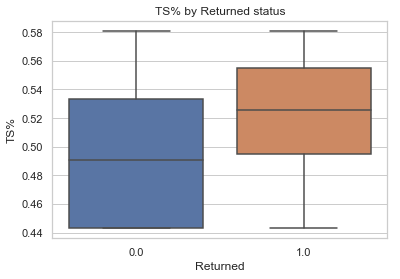

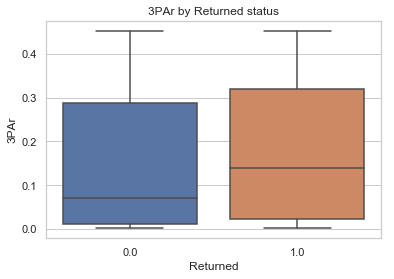

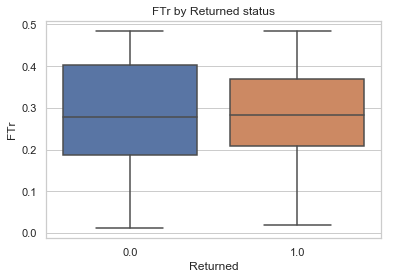

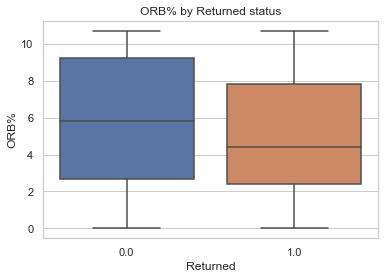

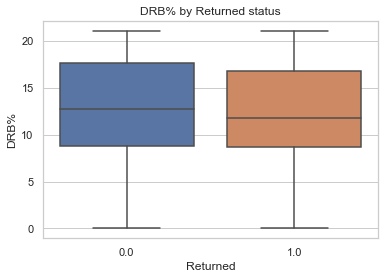

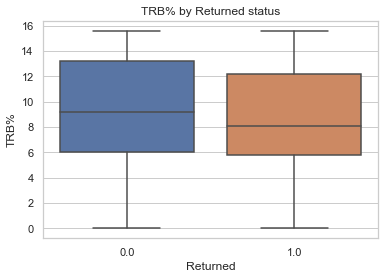

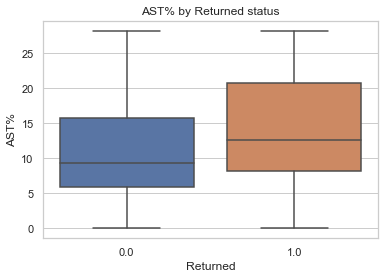

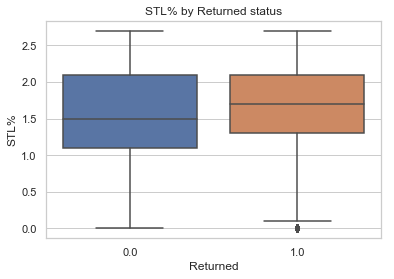

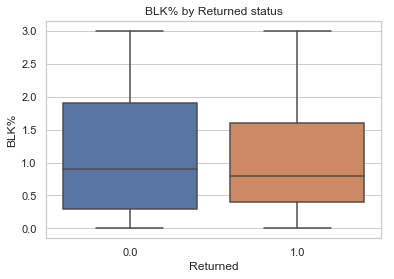

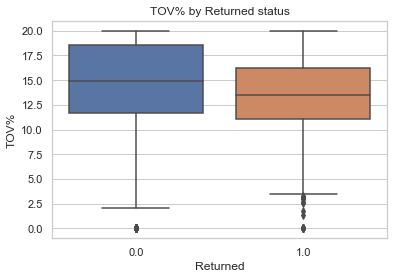

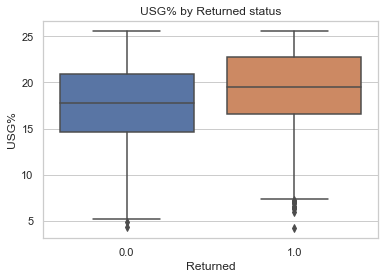

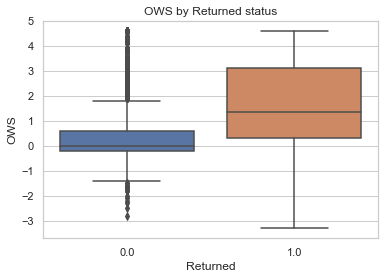

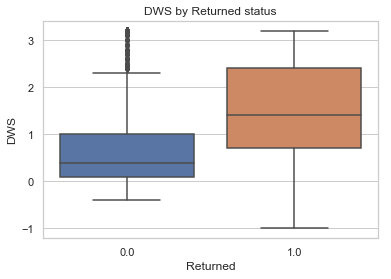

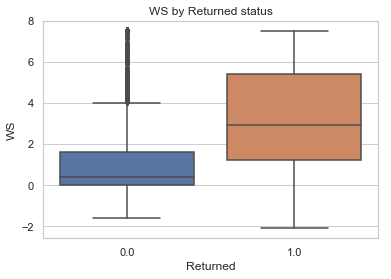

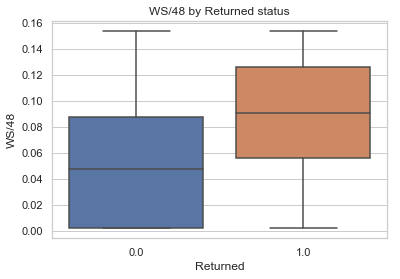

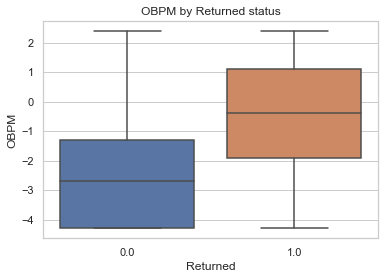

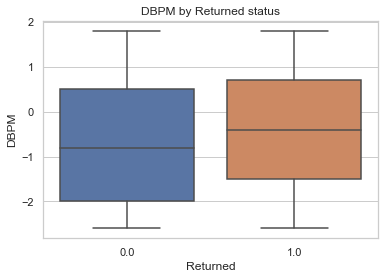

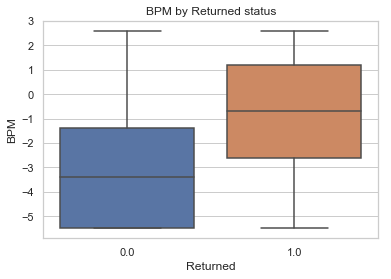

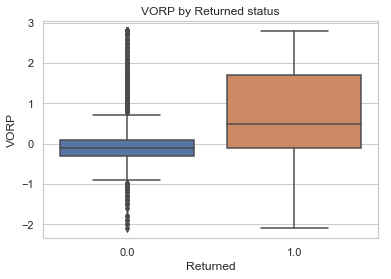

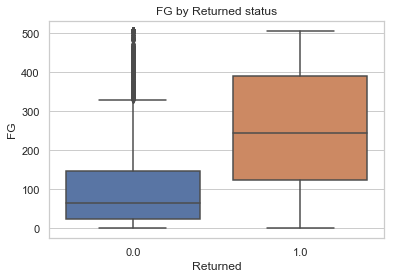

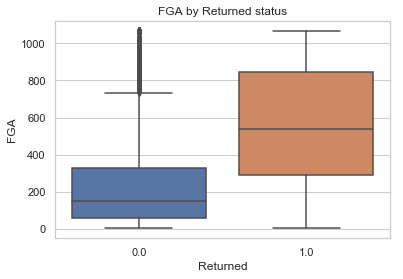

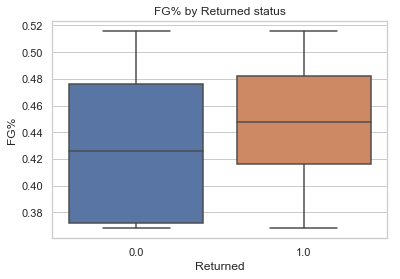

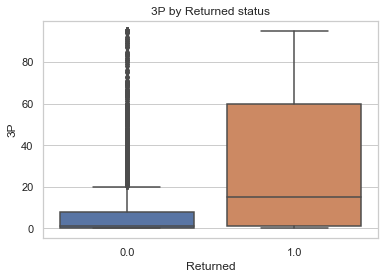

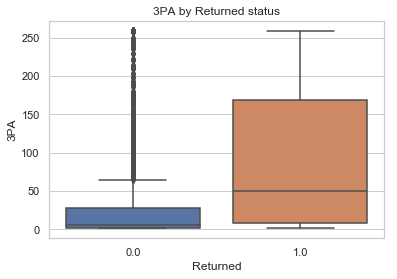

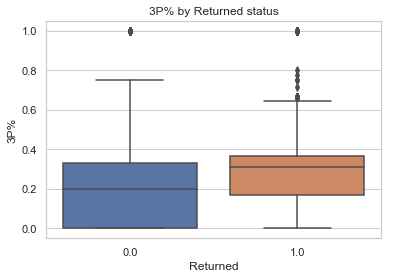

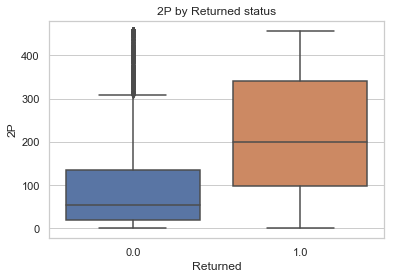

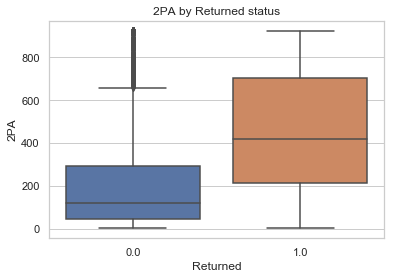

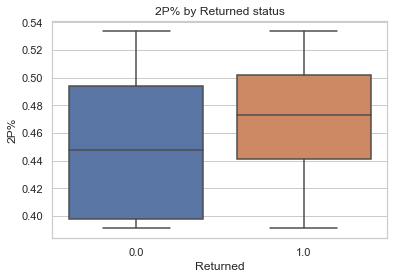

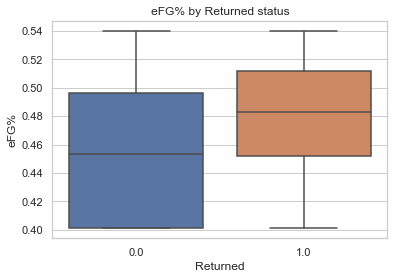

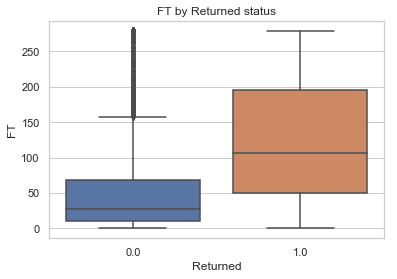

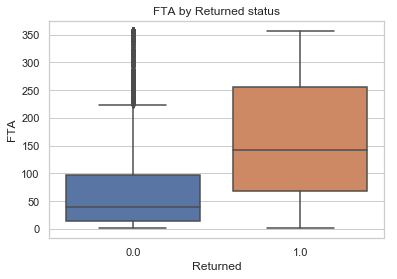

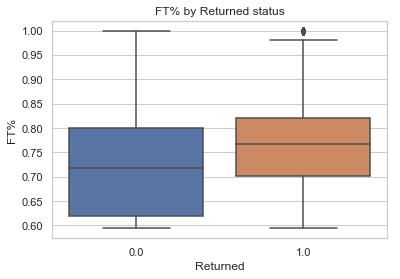

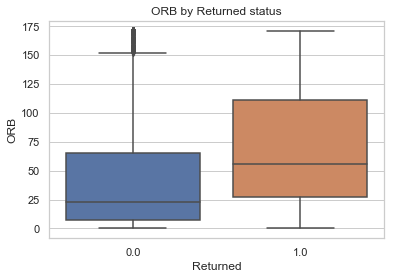

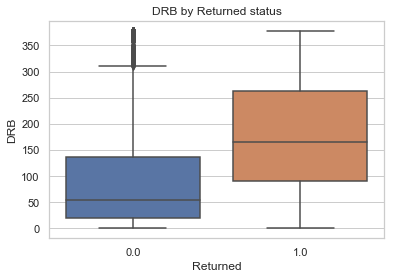

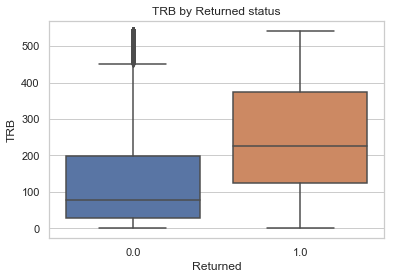

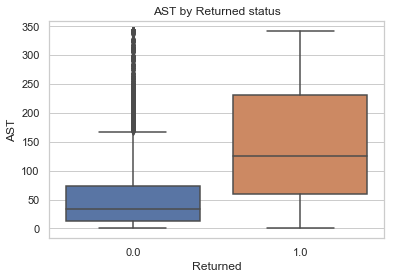

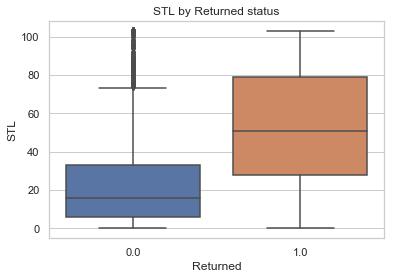

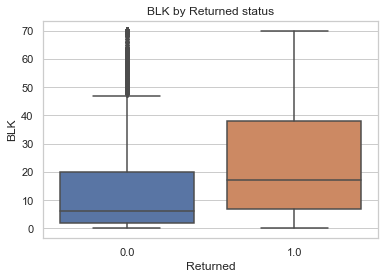

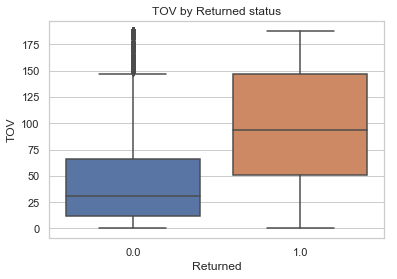

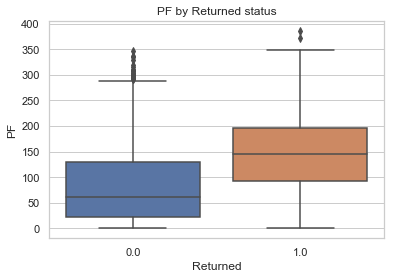

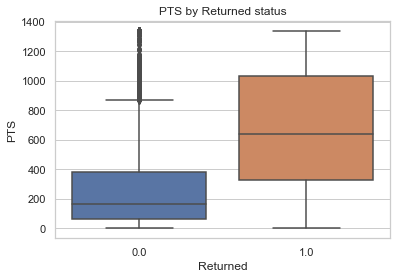

In [25]:
# Do the boxplots on the winsorized data
for col in nba.drop(columns=['Player', 'Tm', 'Pos']):
    if col != 'Returned':
        sns.boxplot(x='Returned', y=col, data=nba)
        plt.title('{} by Returned status'.format(col))
        plt.show()
        plt.close()

The outliers have been much improved. While there is still a handful of the variables that have outliers, it is enough to live with.

# Feature Engineering

At this point, I can drop team, player, and year variables as these are not part of the equation I want to be predicting with.

In [26]:
nba = nba.drop(columns=['Player', 'Tm', 'Year'])

I will also make five dummy categories for positions - PG, SG, SF, PF, and C

In [27]:
nba['Pos-PG'] = np.where(nba['Pos'].str.contains('PG'), 1, 0)
nba['Pos-SG'] = np.where(nba['Pos'].str.contains('SG'), 1, 0)
nba['Pos-SF'] = np.where(nba['Pos'].str.contains('SF'), 1, 0)
nba['Pos-PF'] = np.where(nba['Pos'].str.contains('PF'), 1, 0)
nba['Pos-C'] = np.where(nba['Pos'].str.contains('C'), 1, 0)

nba = nba.drop(columns='Pos')

I will now run the variables through normalization and then select 10 features to model with based on the SelectKBest algorithm informed by f_classif, which measures ANOVA F-values. I will then put the training data through the SMOTETomek technique to fight class imbalance. This will synthetically over-sample and under-sample with an algorithm that will not just randomly remove or replicate rows, but create new ones that are similar to the data that we have.

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = pd.concat([pd.DataFrame(normalize(nba.loc[:,:'PTS']), columns=nba.loc[:,:'PTS'].columns),
               nba.loc[:, 'Pos-PG':'Pos-C']],
              axis=1)
y = nba['Returned']

X_new = SelectKBest(f_classif, k=10).fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Resamlping to fight class imbalance
smt = SMOTETomek(sampling_strategy=1.0, random_state=42)

X_train, y_train = smt.fit_resample(X_train, y_train)

# Classical Machine Learning Model Tuning and Evaluation

I will first run a GridSearchCV on the four models I will test on my features: Logistic Regression, Random Forest Classification, Gradient Boosting Classification, and SVC. I will make a function that runs GridSearchCV on each of these models, stores the various metric scores for the optimized versions of each of these models along with the optimal hyperparameters, and then prints a report on the confusion matrix and metric scores for the optimal versions of each model.

In [30]:
best_models = []

def get_best_models(X_train, y_train, X_test, y_test):
    for model in [
        ['Logistic Regression', LogisticRegression(), 
         {'C': np.logspace(-3,3,7),
          'penalty': ['l1','l2']}
        ],
        ['Random Forest Classifier', RandomForestClassifier(), 
         {'n_estimators': [100, 200, 300],
          'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth': [3,4,5],
          'criterion': ['gini', 'entropy']}
        ],
        ['Gradient Boosting Classifier', GradientBoostingClassifier(),
         {'loss': ['deviance', 'exponential'],
          'learning_rate': [0.01, 0.05, 0.1, 0.2],
          'max_depth': [3,4,5],
          'max_features': ['log2','sqrt'],
          'n_estimators': [100, 200, 300]}
        ],
        ['SVC', SVC(), 
         {'C': [0.001, 0.01, 0.1, 1, 10],
          'gamma': [0.001, 0.01, 0.1, 1]}
        ]
                    ]:
        grid = GridSearchCV(estimator=model[1], param_grid=model[2], cv=5, verbose=1)
        grid.fit(X_train, y_train)
        score = grid.score(X_test, y_test)
        y_pred = grid.predict(X_test)
        best_models.append([model[0], score, f1_score(y_test, y_pred),
                            precision_score(y_test, y_pred), 
                            recall_score(y_test, y_pred), grid.best_params_])
        print('{} Model Confusion Matrix: '.format(model[0]))
        print('--------------------------------------------')
        print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
        print('--------------------------------------------')
        print('{} Scores: '.format(model[0]))
        print('F1 score: {}'.format(f1_score(y_test, y_pred)))
        print('Precision score: {}'.format(precision_score(y_test, y_pred)))
        print('Recall score: {}'.format(recall_score(y_test, y_pred)))
        print('Mean accuracy score: {}'.format(score))
        print('{} Best Parameters:'.format(model[0]), grid.best_params_)
        print('--------------------------------------------')
        print('--------------------------------------------')
        print('--------------------------------------------\n')
        
get_best_models(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    5.4s finished


Logistic Regression Model Confusion Matrix: 
--------------------------------------------
Predicted  0.0   1.0   All
True                      
0.0        363   163   526
1.0        368  1489  1857
All        731  1652  2383
--------------------------------------------
Logistic Regression Scores: 
F1 score: 0.8486748361356513
Precision score: 0.9013317191283293
Recall score: 0.8018309100700054
Mean accuracy score: 0.7771716323961393
Logistic Regression Best Parameters: {'C': 1000.0, 'penalty': 'l1'}
--------------------------------------------
--------------------------------------------
--------------------------------------------

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 11.5min finished


Random Forest Classifier Model Confusion Matrix: 
--------------------------------------------
Predicted  0.0   1.0   All
True                      
0.0        395   131   526
1.0        511  1346  1857
All        906  1477  2383
--------------------------------------------
Random Forest Classifier Scores: 
F1 score: 0.8074385122975406
Precision score: 0.9113067027758971
Recall score: 0.724824986537426
Mean accuracy score: 0.7305916911456147
Random Forest Classifier Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
--------------------------------------------
--------------------------------------------
--------------------------------------------

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 23.6min finished


Gradient Boosting Classifier Model Confusion Matrix: 
--------------------------------------------
Predicted  0.0   1.0   All
True                      
0.0        335   191   526
1.0        416  1441  1857
All        751  1632  2383
--------------------------------------------
Gradient Boosting Classifier Scores: 
F1 score: 0.8260246488965319
Precision score: 0.8829656862745098
Recall score: 0.7759827679052235
Mean accuracy score: 0.7452790600083928
Gradient Boosting Classifier Best Parameters: {'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 300}
--------------------------------------------
--------------------------------------------
--------------------------------------------

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 28.9min finished


SVC Model Confusion Matrix: 
--------------------------------------------
Predicted  0.0   1.0   All
True                      
0.0        343   183   526
1.0        377  1480  1857
All        720  1663  2383
--------------------------------------------
SVC Scores: 
F1 score: 0.8409090909090909
Precision score: 0.8899579073962718
Recall score: 0.7969843834141088
Mean accuracy score: 0.7650020981955519
SVC Best Parameters: {'C': 10, 'gamma': 1}
--------------------------------------------
--------------------------------------------
--------------------------------------------



I will now make graphs that compare the optimized version of these models by the various metrics

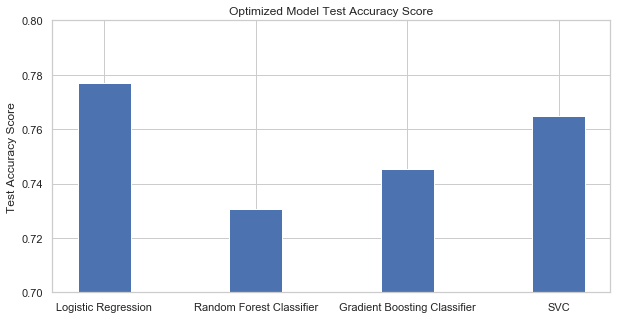

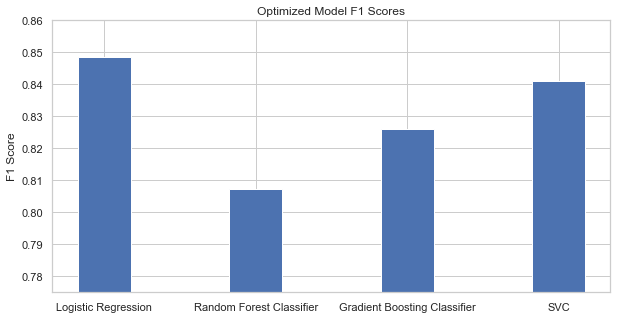

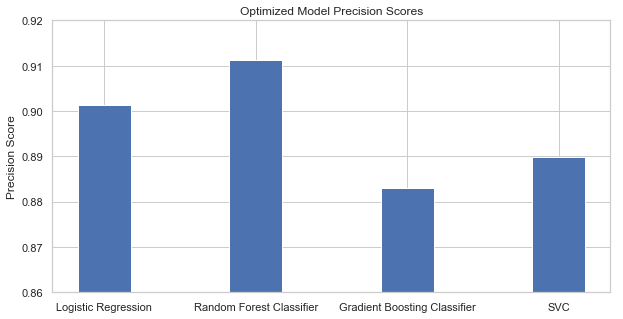

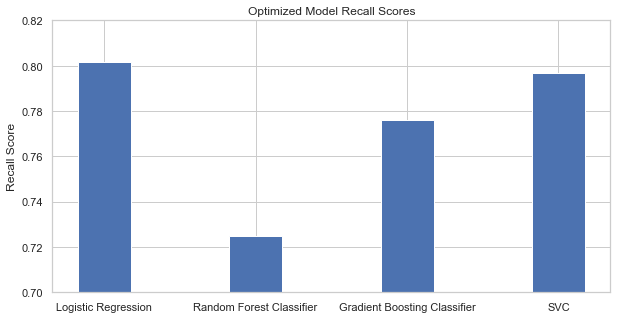

In [36]:
model_names = []
model_testscores = []
model_f1scores = []
model_precisionscores = []
model_recallscores = []
for model in best_models:
    model_names.append(model[0])
    model_testscores.append(model[1])
    model_f1scores.append(model[2])
    model_precisionscores.append(model[3])
    model_recallscores.append(model[4])

ind = np.arange(4)

plt.figure(figsize=(10,5))   
plt.bar(ind, model_testscores, width=0.35)
plt.xticks(ind, model_names)
plt.ylim(0.7,0.8)
plt.ylabel('Test Accuracy Score')
plt.title('Optimized Model Test Accuracy Score')
plt.show()

plt.figure(figsize=(10,5))   
plt.bar(ind, model_f1scores, width=0.35)
plt.xticks(ind, model_names)
plt.ylim(0.775,0.86)
plt.ylabel('F1 Score')
plt.title('Optimized Model F1 Scores')
plt.show()

plt.figure(figsize=(10,5))   
plt.bar(ind, model_precisionscores, width=0.35)
plt.xticks(ind, model_names)
plt.ylim(0.86,0.92)
plt.ylabel('Precision Score')
plt.title('Optimized Model Precision Scores')
plt.show()

plt.figure(figsize=(10,5))   
plt.bar(ind, model_recallscores, width=0.35)
plt.xticks(ind, model_names)
plt.ylim(0.7,0.82)
plt.ylabel('Recall Score')
plt.title('Optimized Model Recall Scores')
plt.show()

The optimized Logistic Regression model has the best score in three of the four metrics - Test Accuracy Score, F1 Score, and Recall Score- while it ranked second in Precision Score. Based on these results, I would choose the Logistic Regression model to put into production. But first I will create some Multiple Layer Perceptron Neural Networks and test their accuracy. If any have an accuracy greater than the Logistic Regression mean accuracy of 0.777, then I will choose that version of a Neural Network instead.

# Neural Networks

In [37]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam

# Import the backend
from keras import backend as K 

y_train_keras = keras.utils.to_categorical(y_train, 2)
y_test_keras = keras.utils.to_categorical(y_test, 2)

In [38]:
neuralnet_scores = []

model_1 = Sequential()

model_1.add(Dense(64, activation='relu', input_shape=(10,)))
model_1.add(Dropout(0.1))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(2, activation='softmax'))

# Compile the model to put it all together.
model_1.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

model_1.fit(X_train, y_train_keras,
            batch_size=128,
            epochs=10,
            verbose=1,
            validation_data=(X_test, y_test_keras))
score_1 = model_1.evaluate(X_test, y_test_keras, verbose=0)
neuralnet_scores.append(score_1[1])
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 14290 samples, validate on 2383 samples
Epoch 1/10
14290/14290 [==============================] - 2s 146us/step - loss: 0.6198 - acc: 0.7023 - val_loss: 0.5947 - val_acc: 0.7747
Epoch 2/10
14290/14290 [==============================] - 1s 37us/step - loss: 0.5641 - acc: 0.7271 - val_loss: 0.5783 - val_acc: 0.7449
Epoch 3/10
14290/14290 [==============================] - 1s 35us/step - loss: 0.5479 - acc: 0.7358 - val_loss: 0.5591 - val_acc: 0.7335
Epoch 4/10
14290/14290 [==============================] - 0s 35us/step - loss: 0.5398 - acc: 0.7402 - val_loss: 0.5701 - val_acc: 0.7167
Epoch 5/10
14290/14290 [==============================] - 0s 34us/step - loss: 0.5367 - acc: 0.7432 - val_loss: 0.5720 - val_acc: 0.7088
Epoch 6/10
14290/14290 [======

In [39]:
model_2 = Sequential()

model_2.add(Dense(512, activation='relu', input_shape=(10,)))
model_2.add(Dropout(0.1))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(2, activation='softmax'))

model_2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model_2.fit(X_train, y_train_keras,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test_keras))
score_2 = model_2.evaluate(X_test, y_test_keras, verbose=0)
neuralnet_scores.append(score_2[1])
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Train on 14290 samples, validate on 2383 samples
Epoch 1/10
14290/14290 [==============================] - 4s 301us/step - loss: 0.5776 - acc: 0.7145 - val_loss: 0.5419 - val_acc: 0.7302
Epoch 2/10
14290/14290 [==============================] - 2s 137us/step - loss: 0.5509 - acc: 0.7364 - val_loss: 0.4795 - val_acc: 0.7663
Epoch 3/10
14290/14290 [==============================] - 2s 134us/step - loss: 0.5412 - acc: 0.7420 - val_loss: 0.5274 - val_acc: 0.7075
Epoch 4/10
14290/14290 [==============================] - 2s 133us/step - loss: 0.5393 - acc: 0.7390 - val_loss: 0.5594 - val_acc: 0.6878
Epoch 5/10
14290/14290 [==============================] - 2s 133us/step - loss: 0.5358 - acc: 0.7421 - val_loss: 0.5101 - val_acc: 0.7381
Epoch 6/10
14290/14290 [==============================] - 2s 133us/step - loss: 0.5349 - acc: 0.7449 - val_loss: 0.5252 - val_acc: 0.7289
Epoch 7/10
14290/14290 [==============================] - 2s 130us/step - loss: 0.5332 - acc: 0.7418 - val_loss: 0.4924 - v

I will try again, this time setting the optimizer to Adam and adding to the batch size and epochs.

In [40]:
model_3 = Sequential()

model_3.add(Dense(512, activation='relu', input_shape=(10,)))
model_3.add(Dropout(0.1))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(2, activation='softmax'))

model_3.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model_3.fit(X_train, y_train_keras,
          batch_size=254,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test_keras))
score_3 = model_3.evaluate(X_test, y_test_keras, verbose=0)
neuralnet_scores.append(score_3[1])
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

Train on 14290 samples, validate on 2383 samples
Epoch 1/50
14290/14290 [==============================] - 4s 292us/step - loss: 0.5816 - acc: 0.7111 - val_loss: 0.6199 - val_acc: 0.6660
Epoch 2/50
14290/14290 [==============================] - 1s 103us/step - loss: 0.5404 - acc: 0.7407 - val_loss: 0.4883 - val_acc: 0.7545
Epoch 3/50
14290/14290 [==============================] - 1s 100us/step - loss: 0.5377 - acc: 0.7428 - val_loss: 0.5336 - val_acc: 0.7293
Epoch 4/50
14290/14290 [==============================] - 1s 92us/step - loss: 0.5324 - acc: 0.7453 - val_loss: 0.5089 - val_acc: 0.7407
Epoch 5/50
14290/14290 [==============================] - 1s 102us/step - loss: 0.5307 - acc: 0.7433 - val_loss: 0.5528 - val_acc: 0.7146
Epoch 6/50
14290/14290 [==============================] - 1s 101us/step - loss: 0.5276 - acc: 0.7470 - val_loss: 0.5751 - val_acc: 0.6979
Epoch 7/50
14290/14290 [==============================] - 1s 99us/step - loss: 0.5255 - acc: 0.7467 - val_loss: 0.5288 - val

I will try a model similar to the first, but make some slight adjustments to it.

In [41]:
model_4 = Sequential()

model_4.add(Dense(64, activation='relu', input_shape=(10,)))
model_4.add(Dropout(0.1))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.1))
model_4.add(Dense(2, activation='softmax'))

# Compile the model to put it all together.
model_4.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

model_4.fit(X_train, y_train_keras,
            batch_size=128,
            epochs=20,
            verbose=1,
            validation_data=(X_test, y_test_keras))
score_4 = model_4.evaluate(X_test, y_test_keras, verbose=0)
neuralnet_scores.append(score_4[1])
print('Test loss:', score_4[0])
print('Test accuracy:', score_4[1])

Train on 14290 samples, validate on 2383 samples
Epoch 1/20
14290/14290 [==============================] - 2s 171us/step - loss: 0.6304 - acc: 0.7135 - val_loss: 0.5802 - val_acc: 0.7851
Epoch 2/20
14290/14290 [==============================] - 1s 41us/step - loss: 0.5650 - acc: 0.7291 - val_loss: 0.5489 - val_acc: 0.7633
Epoch 3/20
14290/14290 [==============================] - 1s 38us/step - loss: 0.5494 - acc: 0.7353 - val_loss: 0.5806 - val_acc: 0.7264
Epoch 4/20
14290/14290 [==============================] - 1s 37us/step - loss: 0.5420 - acc: 0.7391 - val_loss: 0.5299 - val_acc: 0.7390
Epoch 5/20
14290/14290 [==============================] - 0s 34us/step - loss: 0.5364 - acc: 0.7413 - val_loss: 0.5600 - val_acc: 0.7130
Epoch 6/20
14290/14290 [==============================] - 1s 37us/step - loss: 0.5357 - acc: 0.7408 - val_loss: 0.5274 - val_acc: 0.7310
Epoch 7/20
14290/14290 [==============================] - 0s 35us/step - loss: 0.5335 - acc: 0.7421 - val_loss: 0.5432 - val_acc

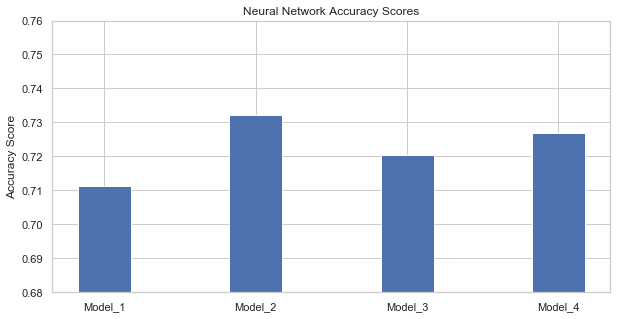

In [42]:
plt.figure(figsize=(10,5))   
plt.bar(ind, neuralnet_scores, width=0.35)
plt.xticks(ind, ['Model_1', 'Model_2', 'Model_3', 'Model_4'])
plt.ylim(0.68,0.76)
plt.ylabel('Accuracy Score')
plt.title('Neural Network Accuracy Scores')
plt.show()

None of the models reach the threshold I set of 0.777 to beat out the Logistic Regression model in terms of accuracy. I will therefore not use the neural network, and will move forward with putting the Logistic Regression model into production.

# Production Model

In [43]:
lr = LogisticRegression (penalty='l1', C=1000.0, solver='liblinear')

MODEL = lr.fit(X_train, y_train)

MODEL.score(X_test, y_test)

0.7763323541754091

# Final Analysis

Based on all of the comparative analysis I've done of optimized models and neural networks, the Logistic Regression model with l1 penalty, C set to 1000, and the default liblinear solver is the best model to put into production for the problem at hand --  predicting whether an NBA player will play next season.

When scoring this model against the test data, it scored a 0.776. This essentially means that we can have around 78% accuracy on average when giving a prediction for a player's statstical profile on whether they will return to play another NBA season. That is the best accuracy among the models that I optimized. It also has the highest F1 score (balanced Recall and Precision). This means that in the Confusion Matrix, the model had the best overall performance of correctly assigning player who return as returned and players who don't return as not returning. Since the classes are imbalanced, I had to perform synthetic balancing on the training data to achieve this type of balanced accuracy where both classes have accuracy in the actual imbalanced testing data.

In order to put this in an actual production environment, you would simply deploy the model with the scripts that built and trained it from this notebook and would have the ability to feed a player's basketball-reference statistics into the model, and the model would give a prediction of 0 (for not returning) or 1 (for returning). 

To keep this updated in the future, I would need to retrain it at the end of each season as a new season's data come in. Upkeep would be very simple as it is only season long stats that it trains on, so training upkeep would only be once a year.

As stated in the beginning, NBA teams, player agents, and NBA media and consumers would find value in such a model as a way to find value in their respective way of interacting with the league. Teams could ensure that they are giving contracts to valuable players, agents can prepare players for the likelihood of not getting a new contract, media outlets can use it as a way to write about the league, and consumers can use it on prop bets or just as a fun way to interact with the league.